# RDFIA: Practical work 2-c
## Domain Adaptation
### Sorbonne Université 2024
### [Course link](https://rdfia.github.io/)
### GRUSS Carlos, RCHAKI Oussama

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

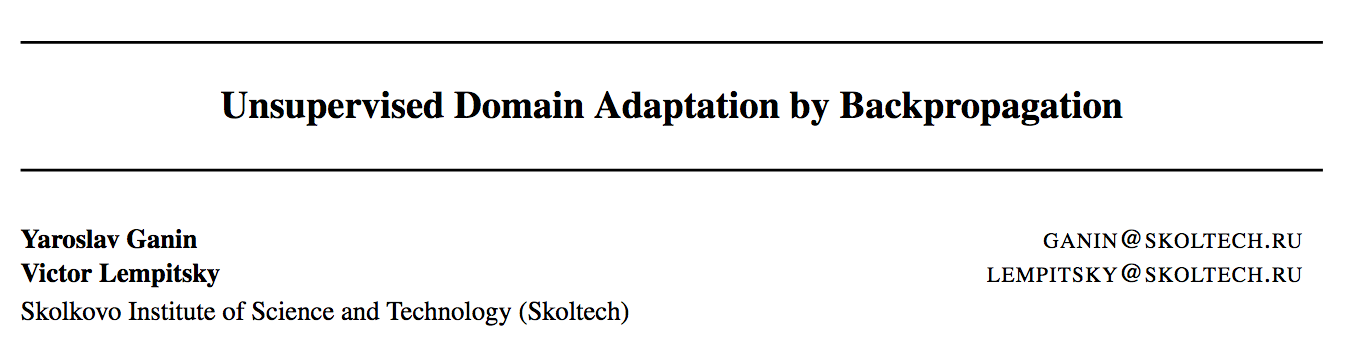

In [1]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"]="1"

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [3]:
if not os.path.exists('mnistm.py'):
    !wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

In [ ]:
if not os.path.exists('MNIST'):
    from mnistm import create_mnistm
    create_mnistm()

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [5]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255 # Shape (60000, 28, 28)

mean = mnist_pixels.mean().item() # Compute the mean across all dimensions of the tensor
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")

mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [6]:
# Repeat MNIST grayscale images 3 times to make it compatible with MNIST-M (RGB)
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

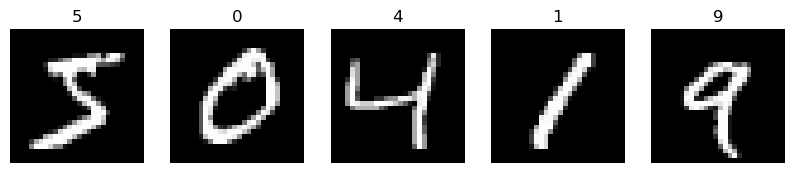

In [7]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0) # Denormalize and permute dimensions to (H, W, C)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [8]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

print(f"mnistm_data: {list(mnist_m.keys())}")
print(f"Shape of train: {mnist_m['x_train'].shape}")
print(f"Shape of test: {mnist_m['x_test'].shape}")

mnistm_data: ['x_train', 'x_test', 'y_train', 'y_test']
Shape of train: (60000, 28, 28, 3)
Shape of test: (10000, 28, 28, 3)


In [ ]:
class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

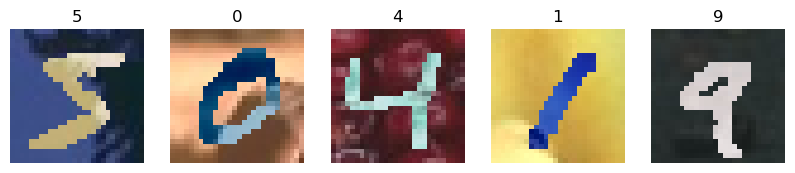

In [10]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

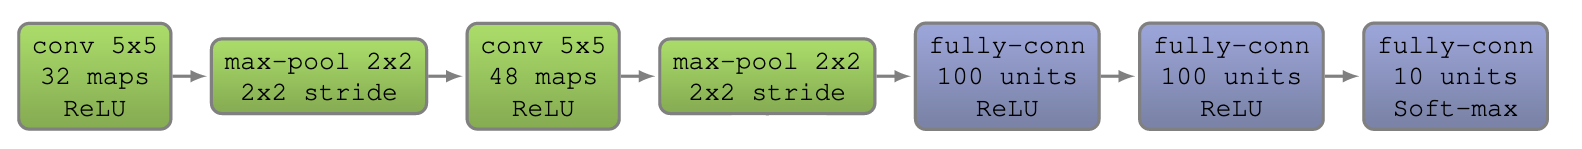

In [11]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=5, padding=2), # stride=1, padding=2 to keep the same size (32, 28, 28)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 pooling halfs the spatial dim (32, 14, 14)
      nn.Conv2d(32, 48, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # (48, 14, 14) -> (48, 7, 7)
    )

    self.classif = nn.Sequential(
      nn.Linear(48 * 7 * 7, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10),
      # nn.Softmax(dim=1) # softmax is included in the loss function
    )

  def forward(self, x):
    x = self.cnn(x)
    x = x.view(-1, 48 * 7 * 7)
    x = self.classif(x)
    return x

NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [12]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [13]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y) # y is class index, not one-hot
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.3367
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.05983
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.04095
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03269
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.02782
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02432
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.02167
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.01954
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.0178
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01636
	Learning rate = 0.0016556002607617019
Test loss: 0.02697, test acc: 99.03


Performance on less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: Can our model generalize on the slightly different domain of MNIST-M?

In [14]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.65157, test acc: 51.96


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

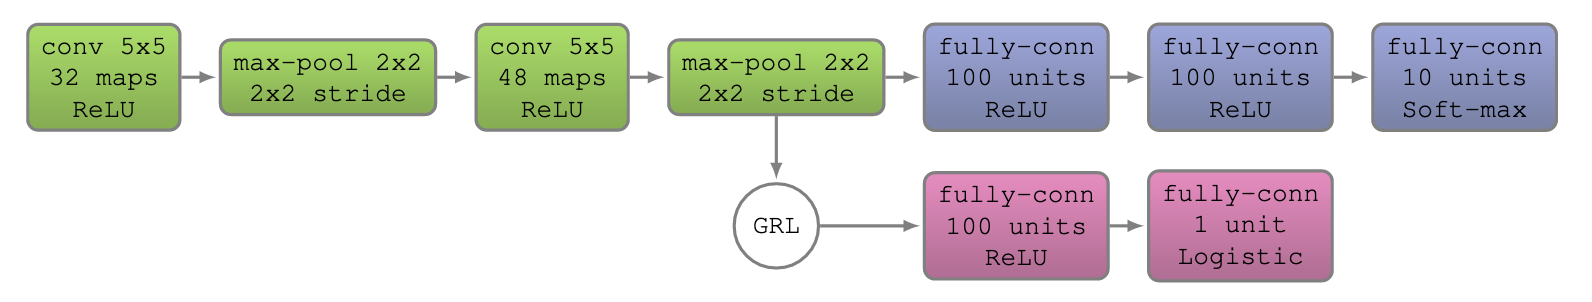

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient.

[For reference](https://pytorch.org/docs/stable/generated/torch.autograd.function.FunctionCtx.save_for_backward.html#torch.autograd.function.FunctionCtx.save_for_backward)

In [13]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    # Store factor in the context (ctx) of the class (method saved_for_backward)
    ctx.save_for_backward(torch.tensor(factor)) 
    # Return the input tensor x as is
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors # saved_tensors attribute can be used to retrieve the factor

    reversed_grad = grad * factor

    # Backward method should return a tuple with the same number of elements 
    # as the number of inputs to the forward method
    # We return the gradient of the input, which is the first argument to the forward method
    # and None for the second argument, which is the factor (since it won't be updated)
    return reversed_grad, None

To use a PyTorch's `Function`, call its apply

In [14]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

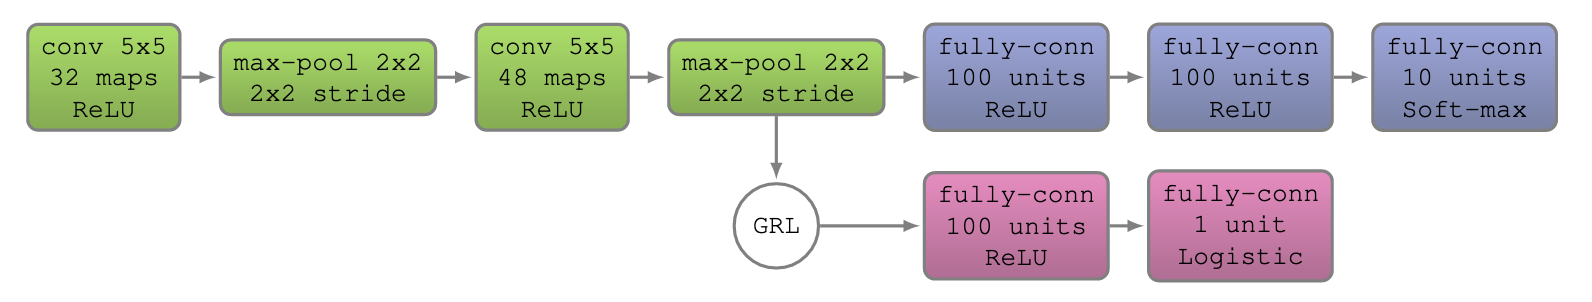

In [15]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=5, padding=2), # stride=1, padding=2 to keep the same size (32, 28, 28)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 pooling halfs the spatial dim (32, 14, 14)
      nn.Conv2d(32, 48, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # (48, 14, 14) -> (48, 7, 7)
    )

    self.classif = nn.Sequential(
      nn.Linear(48 * 7 * 7, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10),
      # nn.Softmax(dim=1) # softmax is included in the loss function
    )


    self.domain = nn.Sequential(
      nn.Linear(48 * 7 * 7, 100),
      nn.ReLU(),
      nn.Linear(100, 1)
    )

  def forward(self, x, factor=1):
    # Compute the feature vector
    x = self.cnn(x)
    x = x.view(-1, 48 * 7 * 7)

    # Compute the class prediction
    class_pred = self.classif(x)

    # Compute the domain prediction
    x = GradientReversal.apply(x, -1*factor) # GRL layer
    domain_pred = self.domain(x)

    return class_pred, domain_pred

In [16]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [19]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

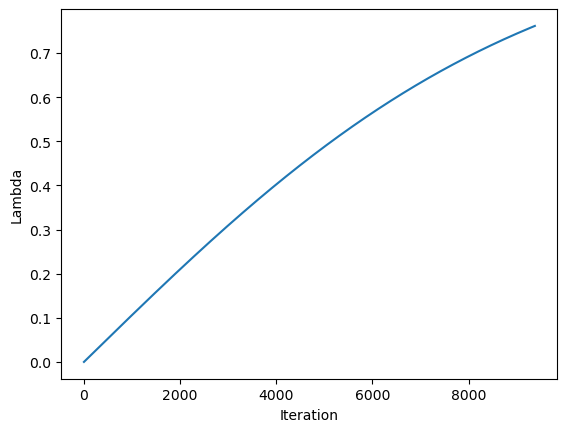

In [18]:
epochs = 20

nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)
plt.xlabel('Iteration')
plt.ylabel('Lambda')
plt.show()

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [21]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0 # number of batches seen
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    # source input and label
    xs, ys = xs.cuda(), ys.cuda()

    # target input (no label since unsupervised)
    xt = xt.cuda()

    # concatenate source and target inputs
    x = torch.cat((xs, xt))

    optimizer.zero_grad()

    # Forward pass
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # Compute the source classification loss
    ce = F.cross_entropy(cls_logits[:len(xs)], ys)

    # Compute the domain loss
    # ground truth is 1 for inputs in source and 0 for inputs in target
    bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())

    loss = ce + bce
    loss.backward()

    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0


Epoch 0, class loss: 0.24791, domain loss: 0.04724
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.05173, domain loss: 0.05298
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.0335, domain loss: 0.0795
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02653, domain loss: 0.09691
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02521, domain loss: 0.10768
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02637, domain loss: 0.13019
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.04407, domain loss: 0.1456
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.03142, domain loss: 0.1628
GRL factor 0.379948962255225
Epoch 8, class loss: 0.04002, domain loss: 0.20189
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.03967, domain loss: 0.22432
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.04876, domain loss: 0.25675
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.05053, domain loss: 0.26066
GRL factor 0.5370495669980351
Epoch 12, class loss: 0.0356,

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [19]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **It is super slow**, so we will compute it on a subset of the data
- **It is not determinist**, so you can have different results everytime
- **It can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [20]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


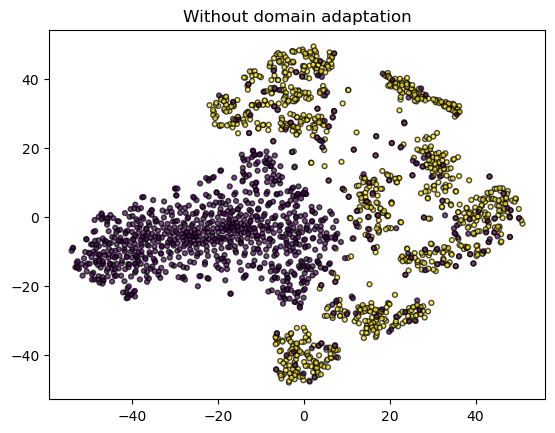

In [24]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

# Take 1000 random indexes
indexes = np.random.permutation(len(source_emb))[:1000]

# Take 1000 random embeddings from source and target and concatenate them
emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
# Create the domain labels
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains, alpha=0.7, edgecolors='black', s=12)
plt.title("Without domain adaptation")
plt.show()

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


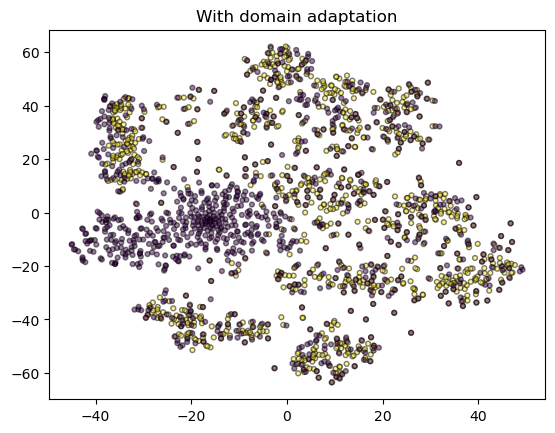

In [25]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains, alpha=0.5, edgecolors='black', s=12)
plt.title("With domain adaptation")
plt.show()

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

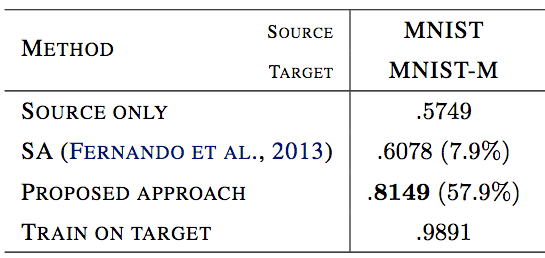

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- Use much more epochs
- Modify the learning rate scheduler to be updated per step
- Test different standardization
- Different GRL factor scheduling

In [31]:
epochs = 100

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

# Create arrays to store the loss and accuracy values for later plotting
source_cls_loss, source_domain_loss = [], []
target_cls_loss, target_domain_loss = [], []
target_cls_acc = []

b = 0 # number of batches seen
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    # source input and label
    xs, ys = xs.cuda(), ys.cuda()

    # target input (no label since unsupervised)
    xt = xt.cuda()

    # concatenate source and target inputs
    x = torch.cat((xs, xt))

    optimizer.zero_grad()

    # Forward pass
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # Compute the source classification loss
    ce = F.cross_entropy(cls_logits[:len(xs)], ys)

    # Compute the domain loss
    # ground truth is 1 for inputs in source and 0 for inputs in target
    bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda())

    loss = ce + bce
    loss.backward()

    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')

  source_cls_loss.append(cls_loss)
  source_domain_loss.append(domain_loss)

  # Evaluate the model on the target domain
  c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_train_loader, source=False)
  target_cls_loss.append(c_loss)
  target_domain_loss.append(d_loss)
  target_cls_acc.append(c_acc)

  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0


Epoch 0, class loss: 0.35833, domain loss: 0.06318
GRL factor 0.00999966667999952
Epoch 1, class loss: 0.0635, domain loss: 0.01871
GRL factor 0.01999733375993107
Epoch 2, class loss: 0.04107, domain loss: 0.01189
GRL factor 0.02999100323881998
Epoch 3, class loss: 0.03065, domain loss: 0.01031
GRL factor 0.039978680311163695
Epoch 4, class loss: 0.02412, domain loss: 0.01029
GRL factor 0.049958374957880025
Epoch 5, class loss: 0.01959, domain loss: 0.01407
GRL factor 0.05992810352914346
Epoch 6, class loss: 0.01695, domain loss: 0.03309
GRL factor 0.069885890316429
Epoch 7, class loss: 0.01389, domain loss: 0.03678
GRL factor 0.07982976911113138
Epoch 8, class loss: 0.0125, domain loss: 0.05379
GRL factor 0.08975778474716023
Epoch 9, class loss: 0.00999, domain loss: 0.05025
GRL factor 0.0996679946249559
Epoch 10, class loss: 0.00859, domain loss: 0.05394
GRL factor 0.10955847021442966
Epoch 11, class loss: 0.00733, domain loss: 0.05702
GRL factor 0.11942729853438583
Epoch 12, class l

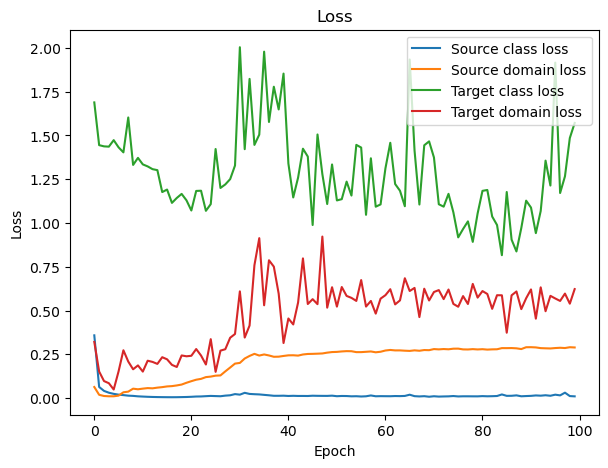

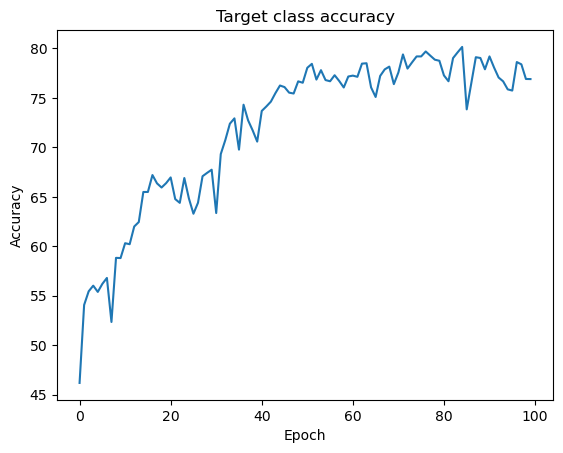

In [32]:
# Plot the loss and accuracy values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(source_cls_loss, label="Source class loss")
plt.plot(source_domain_loss, label="Source domain loss")
plt.plot(target_cls_loss, label="Target class loss")
plt.plot(target_domain_loss, label="Target domain loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the accuracy values
plt.plot(target_cls_acc)
plt.title("Target class accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


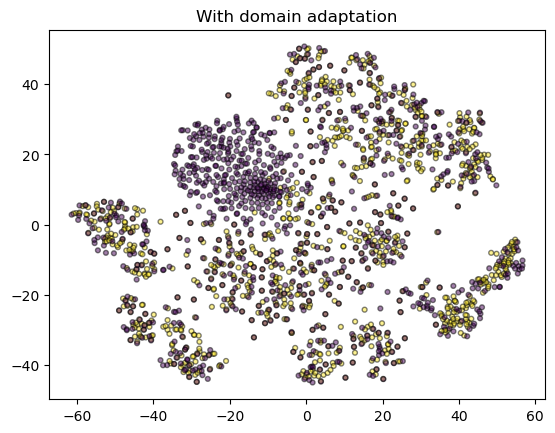

In [33]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains, alpha=0.5, edgecolors='black', s=12)
plt.title("With domain adaptation")
plt.show()